# Modélisation BERT pour classification des images par leur OCR
Oui, après l'OCR et avant la tokenisation pour BERT, vous pouvez nettoyer le texte en supprimant les stop words et en appliquant la lemmatisation. Cependant, la pertinence de ces étapes dépend de l'objectif et du type de modèle que vous utilisez, notamment si vous utilisez un modèle basé sur des transformers comme BERT.

1. Stop Words :
Les stop words sont des mots fréquents qui ont généralement peu de valeur ajoutée pour certaines tâches de NLP traditionnelles, comme les mots fonctionnels ("le", "de", "et", "un", etc.).

Utilisation avec BERT :
Transformers comme BERT sont pré-entraînés pour apprendre à partir du texte brut sans suppression des stop words. BERT peut tirer des informations contextuelles des stop words en raison de son mécanisme d'attention.
Supprimer les stop words n'est pas nécessaire avec BERT et peut parfois même être contre-productif, car ces mots jouent un rôle dans le contexte des phrases. BERT utilise tout le texte, y compris les stop words, pour comprendre le sens du contenu.
Conseil : Pour des tâches avec des modèles comme BERT, il est généralement préférable de ne pas retirer les stop words. Cependant, pour d'autres types de modèles plus simples (comme les TF-IDF ou des modèles de régression logistique), supprimer les stop words peut aider à simplifier le texte.

2. Lemmatisation :
La lemmatisation consiste à réduire un mot à sa forme canonique (par exemple, "courir" au lieu de "courait" ou "couru"). Cela peut être utile pour réduire la variance linguistique en regroupant des formes similaires de mots.

Utilisation avec BERT :
BERT est capable de gérer différentes formes de mots grâce à son apprentissage sur de grands corpus de texte, où il a appris les relations entre les différentes formes des mots. La lemmatisation est donc moins importante avec BERT.
BERT utilise des sous-tokens pour traiter les mots rares ou complexes, ce qui permet de capturer des relations même sans lemmatisation.
Conseil : Comme BERT utilise des sous-tokens et peut traiter différentes formes de mots sans problèmes, la lemmatisation est généralement non nécessaire pour les modèles BERT. Toutefois, cela peut être bénéfique si votre texte OCR contient des erreurs ou des variantes linguistiques excessives.

3. Nettoyage supplémentaire du texte :
En plus de la suppression des stop words et de la lemmatisation, d'autres étapes de nettoyage peuvent être envisagées après l'OCR :

Suppression des caractères spéciaux : Les textes extraits par OCR peuvent contenir des caractères indésirables ou des erreurs.
Correction des fautes d'orthographe : Si votre OCR introduit des fautes de frappe ou des erreurs, corriger ces erreurs avant d'envoyer le texte dans BERT peut améliorer les résultats.

In [ ]:
# Pour l'OCR avec EasyOCR
!pip install easyocr

# Pour les opérations avec PyTorch (déjà inclus dans Google Colab, mais si vous êtes sur un environnement local)
!pip install torch torchvision torchaudio

# Pour utiliser Hugging Face Transformers (pour le modèle BERT et le tokenizer)
!pip install transformers

# Pour manipuler des datasets avec Hugging Face (facultatif mais utile pour gérer les datasets)
!pip install datasets

# Pour travailler avec des DataFrames (par exemple pour `df_ocr`)
!pip install pandas

# Pour la division des jeux de données (train/test split)
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavi

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
#chemin pour trouver les datasets en enregistrer le csv
results_dir = '/content/result/'
# Vérifier si le répertoire results_dir existe et le créer s'il n'existe pas
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

!cp "/content/drive/MyDrive/formation Datascientest/RVL-CDIP/OCR_reducedtrain.csv" "/content/result"

In [ ]:
import pandas as pd

#-------------------------------------------------------------------------------
#paramétrage de lancement
#-------------------------------------------------------------------------------
results_dir = '/content/result/'
csv_name = 'OCR_reducedtrain.csv'
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
df_ocr = pd.read_csv(results_dir + csv_name)
df_ocr['texte_de_ocr'].fillna('', inplace=True)
df_ocr['texte_de_ocr'] = df_ocr['texte_de_ocr'].astype(str)

# Prétraitement du texte pour le pipeline NLP
Nous allons utiliser le tokenizer BERT pour préparer les données textuelles contenues dans la colonne texte_de_ocr de votre DataFrame. Voici comment effectuer le prétraitement des données.

Charger le tokenizer BERT.
Appliquer le tokenizer sur chaque texte de la DataFrame.
Préparer les données pour être compatibles avec un modèle BERT.

In [ ]:
from transformers import BertTokenizer
import torch

# Charger le tokenizer BERT pré-entraîné
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Fonction pour tokeniser le texte
def preprocess_texts(texts):
    # Tokeniser tous les textes dans un seul batch
    tokens = tokenizer(
        texts.tolist(),  # Convertir la colonne en liste
        padding='max_length',  # Remplir les séquences pour qu'elles aient toutes la même longueur
        truncation=True,       # Troncation pour respecter la longueur maximale
        max_length=512,        # Longueur maximale compatible avec BERT
        return_tensors='pt'    # Retourner les tenseurs PyTorch
    )
    return tokens

# Appliquer le prétraitement sur le texte de la DataFrame
tokens = preprocess_texts(df_ocr['texte_de_ocr'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Classification des documents avec BERT
Maintenant que nous avons prétraité les textes, nous allons construire un modèle de classification basé sur BERT. Le modèle va apprendre à prédire les labels des documents à partir des textes extraits.

Charger un modèle BERT pré-entraîné pour la classification.
Préparer les données pour l'entraînement (input_ids, attention_masks, labels).
Entraîner et évaluer le modèle.
5.1. Préparation des données pour l'entraînement
Nous devons associer les textes tokenisés à leurs labels et préparer les tenseurs pour l'entraînement.

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Préparer un dataset personnalisé pour PyTorch
class RVLCDIPDataset(Dataset):
    def __init__(self, tokens, labels):
        self.input_ids = tokens['input_ids']
        self.attention_mask = tokens['attention_mask']
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Créer le dataset à partir des tokens et des labels dans la DataFrame
dataset = RVLCDIPDataset(tokens, df_ocr['label_de_image'].tolist())

# Diviser en train et test (80% train, 20% test)
from sklearn.model_selection import train_test_split
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

# Créer des DataLoader pour l'entraînement et l'évaluation
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Entraînement du modèle BERT pour la classification
Nous allons maintenant charger un modèle BERT pour la classification de séquences et l'entraîner sur le dataset tokenisé.

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Charger le modèle BERT pré-entraîné pour la classification avec 16 labels
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=16)

# Préparer les arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./results',          # Répertoire de sortie
    evaluation_strategy="epoch",     # Évaluer à chaque époque
    per_device_train_batch_size=16,  # Taille de batch pour l'entraînement
    per_device_eval_batch_size=16,   # Taille de batch pour l'évaluation
    num_train_epochs=3,              # Nombre d'époques d'entraînement
    weight_decay=0.01,               # Taux de régularisation
    logging_dir='./logs',            # Répertoire des logs
)

# Créer un objet Trainer pour gérer l'entraînement
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Entraîner le modèle
trainer.train()

# Évaluer le modèle
trainer.evaluate()

# Effectuer l'évaluation
results = trainer.evaluate()
print(f"Evaluation results: {results}")

# Sauvegarder les résultats dans un fichier texte
with open("evaluation_results.txt", "w") as f:
    for key, value in results.items():
        f.write(f"{key}: {value}\n")

print("Les résultats d'évaluation ont été sauvegardés dans 'evaluation_results.txt'.")

import json
# Sauvegarder les résultats dans un fichier JSON
with open("evaluation_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("Les résultats d'évaluation ont été sauvegardés dans 'evaluation_results.json'.")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.129400,0.944044
2,0.781600,0.834083
3,0.511900,0.799560


Evaluation results: {'eval_loss': 0.7995599508285522, 'eval_runtime': 154.7347, 'eval_samples_per_second': 31.021, 'eval_steps_per_second': 1.939, 'epoch': 3.0}
Les résultats d'évaluation ont été sauvegardés dans 'evaluation_results.txt'.
Les résultats d'évaluation ont été sauvegardés dans 'evaluation_results.json'.


# sauvegarde du modèle

In [ ]:
import os
import shutil

# Spécifier le répertoire où enregistrer le modèle
output_dir = 'content/saved_model/'

# Vérifier si le répertoire existe, sinon le créer
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Répertoire {output_dir} créé avec succès.")
else:
    print(f"Le répertoire {output_dir} existe déjà.")

# Sauvegarder le modèle entraîné
model.save_pretrained(output_dir)

# Sauvegarder le tokenizer utilisé pour la tokenisation
tokenizer.save_pretrained(output_dir)

print(f"Le modèle et le tokenizer ont été sauvegardés dans le répertoire {output_dir}")

drive_model_dir = '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 2/saved_model/'
# Copier le répertoire local vers Google Drive
shutil.copytree(output_dir, drive_model_dir, dirs_exist_ok=True)

print(f"Le répertoire {output_dir} a été copié sur Google Drive à {drive_model_dir}.")

Répertoire content/saved_model/ créé avec succès.
Le modèle et le tokenizer ont été sauvegardés dans le répertoire content/saved_model/
Le répertoire content/saved_model/ a été copié sur Google Drive à /content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 2/saved_model/.


In [ ]:
from torch.utils.data import DataLoader

# Créer un DataLoader pour le test_dataset avec un batch_size approprié
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assurez-vous que le modèle est en mode évaluation
model.eval()

# Déplacer le modèle sur le GPU si disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Listes pour stocker les prédictions et les labels réels
all_predictions = []
all_labels = []

# Boucle pour parcourir les données de test
with torch.no_grad():  # Pas besoin de calculer les gradients pendant l'évaluation
    for batch in test_loader:
        # Récupérer les inputs et les labels depuis le DataLoader
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        # Faire des prédictions avec le modèle
        outputs = model(**inputs)
        logits = outputs.logits

        # Convertir les logits en prédictions de classes
        predictions = torch.argmax(logits, dim=1)

        # Stocker les prédictions et les labels réels
        all_predictions.extend(predictions.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

# Afficher les prédictions et les labels pour vérifier
print(f"Prédictions : {all_predictions[:10]}")
print(f"Labels réels : {all_labels[:10]}")

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Afficher les métriques
print(f"Accuracy : {accuracy}")
print(f"Précision : {precision}")
print(f"Rappel : {recall}")
print(f"F1-score : {f1}")

Prédictions : [15, 8, 9, 7, 13, 2, 4, 10, 11, 7]
Labels réels : [0, 8, 9, 7, 13, 12, 4, 10, 11, 7]
Accuracy : 0.7785416666666667
Précision : 0.7837515996581252
Rappel : 0.7785416666666667
F1-score : 0.7799983076276061


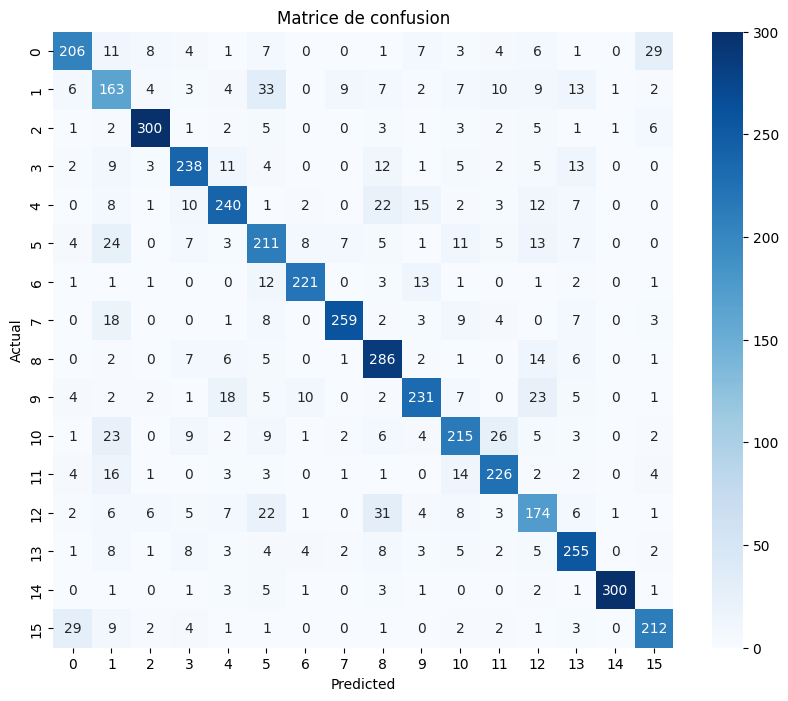

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
cm = confusion_matrix(all_labels, all_predictions)

# Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Dictionnaire des labels (ajustez-le selon votre jeu de données)
labels_dict = {
    0: "letter", 1: "form", 2: "email", 3: "handwritten", 4: "advertisement",
    5: "scientific report", 6: "scientific publication", 7: "specification",
    8: "file folder", 9: "news article", 10: "budget", 11: "invoice",
    12: "presentation", 13: "questionnaire", 14: "resume", 15: "memo"
}
# Obtenir un rapport détaillé avec précision, rappel et F1-score pour chaque classe
rapport = classification_report(all_labels, all_predictions, target_names=list(labels_dict.values()))
print(rapport)

                        precision    recall  f1-score   support

                letter       0.79      0.72      0.75       288
                  form       0.54      0.60      0.57       273
                 email       0.91      0.90      0.91       333
           handwritten       0.80      0.78      0.79       305
         advertisement       0.79      0.74      0.76       323
     scientific report       0.63      0.69      0.66       306
scientific publication       0.89      0.86      0.88       257
         specification       0.92      0.82      0.87       314
           file folder       0.73      0.86      0.79       331
          news article       0.80      0.74      0.77       311
                budget       0.73      0.70      0.72       308
               invoice       0.78      0.82      0.80       277
          presentation       0.63      0.63      0.63       277
         questionnaire       0.77      0.82      0.79       311
                resume       0.99      

<Figure size 1200x800 with 0 Axes>

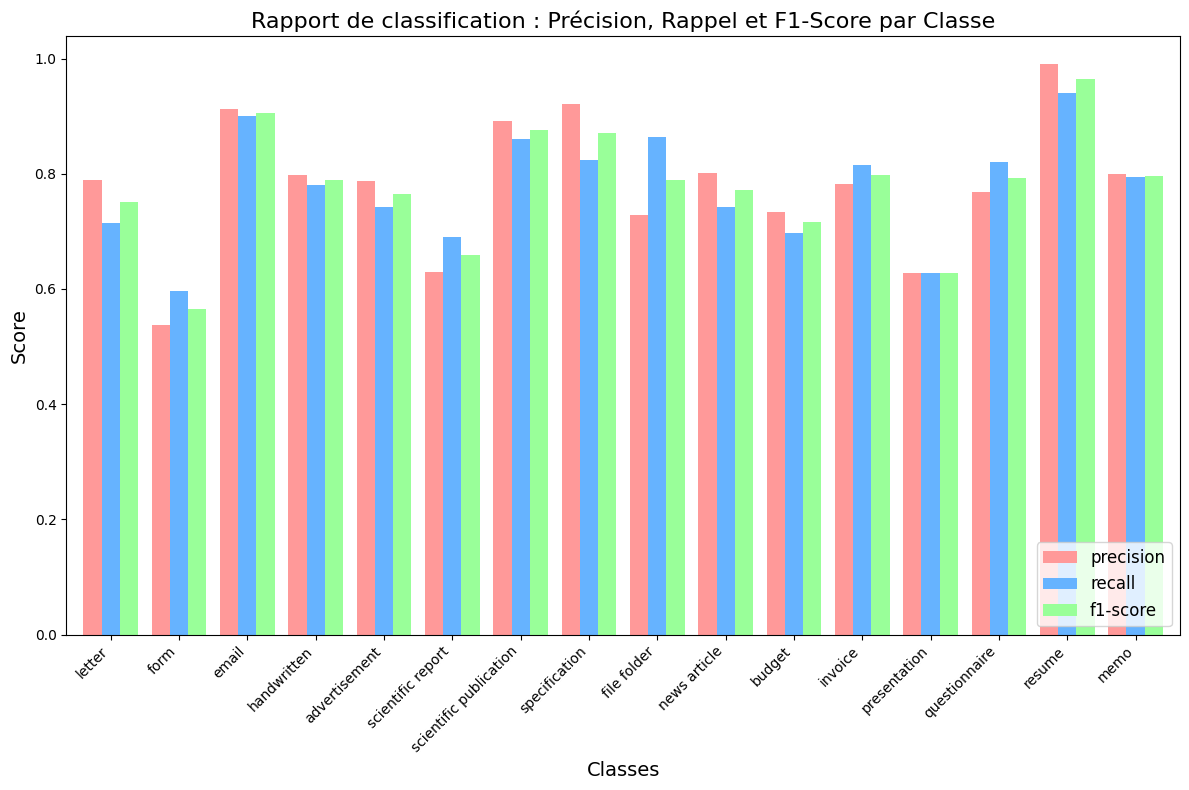

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report



# Générer le rapport de classification en tant que dictionnaire
rapport_dict = classification_report(all_labels, all_predictions, target_names=list(labels_dict.values()), output_dict=True)

# Convertir le dictionnaire en DataFrame pour plus de simplicité
df_rapport = pd.DataFrame(rapport_dict).transpose()

# Sélectionner uniquement les classes (exclure 'accuracy', 'macro avg', 'weighted avg')
df_classes = df_rapport.iloc[:-3, :3]  # On prend uniquement precision, recall et f1-score pour chaque classe

# Créer une figure pour visualiser le rapport
plt.figure(figsize=(12, 8))

# Tracer un graphique à barres pour chaque métrique (précision, rappel, f1-score)
df_classes.plot(kind='bar', figsize=(12, 8), width=0.8, color=['#FF9999', '#66B3FF', '#99FF99'])

# Ajouter des légendes et des titres
plt.title("Rapport de classification : Précision, Rappel et F1-Score par Classe", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xticks(rotation=45, ha="right")  # Rotation des labels de classe pour meilleure lisibilité
plt.legend(loc='lower right', fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.show()


# Rechargement du modele et lancement de 2 epoch supplémentaires

In [ ]:
from transformers import Trainer, TrainingArguments, BertForSequenceClassification, BertTokenizer

# Chemin où le modèle et le tokenizer ont été sauvegardés
drive_model_dir = '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 2/saved_model/'

# Recharger le modèle et le tokenizer
model = BertForSequenceClassification.from_pretrained(drive_model_dir)
tokenizer = BertTokenizer.from_pretrained(drive_model_dir)

# Créer à nouveau les arguments d'entraînement en spécifiant 2 epochs supplémentaires
training_args = TrainingArguments(
    output_dir='./results',          # Où sauvegarder les résultats
    num_train_epochs=2,              # Ajouter 2 epochs supplémentaires
    per_device_train_batch_size=16,  # Taille du batch
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",     # Évaluer à la fin de chaque epoch
    save_strategy="epoch",           # Sauvegarder à la fin de chaque epoch
    logging_dir='./logs',            # Dossier de log
    logging_steps=10
)

# Si vous avez utilisé un Trainer, recharger les arguments et datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

# Continuer l'entraînement pour 2 epochs supplémentaires
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.538200,0.980841
2,0.311300,0.934646


TrainOutput(global_step=2400, training_loss=0.4187965286771456, metrics={'train_runtime': 3879.5052, 'train_samples_per_second': 9.898, 'train_steps_per_second': 0.619, 'total_flos': 1.01047345348608e+16, 'train_loss': 0.4187965286771456, 'epoch': 2.0})

# Evaluation du  modèle sur la totalité du test

# chargement et prétraitement du test

In [3]:
#rapatriment du csv test
import os
#chemin pour trouver les datasets en enregistrer le csv
results_dir = '/content/result/'
# Vérifier si le répertoire results_dir existe et le créer s'il n'existe pas
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

!cp "/content/drive/MyDrive/formation Datascientest/RVL-CDIP/OCR_test_propre.csv" "/content/result"

In [4]:
#chargement du test
import pandas as pd

#-------------------------------------------------------------------------------
#paramétrage de lancement
#-------------------------------------------------------------------------------
results_dir = '/content/result/'
csv_name = 'OCR_test_propre.csv'
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
df_ocr = pd.read_csv(results_dir + csv_name)
df_ocr['texte_de_ocr'].fillna('', inplace=True)
df_ocr['texte_de_ocr'] = df_ocr['texte_de_ocr'].astype(str)

In [5]:
#preprocess du test par BERT
from transformers import BertTokenizer
import torch

# Charger le tokenizer BERT pré-entraîné
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Fonction pour tokeniser le texte
def preprocess_texts(texts):
    # Tokeniser tous les textes dans un seul batch
    tokens = tokenizer(
        texts.tolist(),  # Convertir la colonne en liste
        padding='max_length',  # Remplir les séquences pour qu'elles aient toutes la même longueur
        truncation=True,       # Troncation pour respecter la longueur maximale
        max_length=512,        # Longueur maximale compatible avec BERT
        return_tensors='pt'    # Retourner les tenseurs PyTorch
    )
    return tokens

# Appliquer le prétraitement sur le texte de la DataFrame
tokens = preprocess_texts(df_ocr['texte_de_ocr'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
#création du datatset de test pytorch
from torch.utils.data import Dataset, DataLoader

# Préparer un dataset personnalisé pour PyTorch
class RVLCDIPDataset(Dataset):
    def __init__(self, tokens, labels):
        self.input_ids = tokens['input_ids']
        self.attention_mask = tokens['attention_mask']
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Créer le dataset à partir des tokens et des labels dans la DataFrame
test_dataset = RVLCDIPDataset(tokens, df_ocr['label_de_image'].tolist())

# Créer du DataLoader pour l'évaluation
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
#chargement du modèle
from transformers import Trainer, TrainingArguments, BertForSequenceClassification, BertTokenizer

# Chemin où le modèle et le tokenizer ont été sauvegardés
drive_model_dir = '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 2/saved_model/'

# Recharger le modèle et le tokenizer
model = BertForSequenceClassification.from_pretrained(drive_model_dir)
tokenizer = BertTokenizer.from_pretrained(drive_model_dir)


In [9]:
#Evaluation du modèle sur le test
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assurez-vous que le modèle est en mode évaluation
model.eval()

# Déplacer le modèle sur le GPU si disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Listes pour stocker les prédictions et les labels réels
all_predictions = []
all_labels = []

# Boucle pour parcourir les données de test
with torch.no_grad():  # Pas besoin de calculer les gradients pendant l'évaluation
    for batch in test_loader:
        # Récupérer les inputs et les labels depuis le DataLoader
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        # Faire des prédictions avec le modèle
        outputs = model(**inputs)
        logits = outputs.logits

        # Convertir les logits en prédictions de classes
        predictions = torch.argmax(logits, dim=1)

        # Stocker les prédictions et les labels réels
        all_predictions.extend(predictions.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

# Afficher les prédictions et les labels pour vérifier
print(f"Prédictions : {all_predictions[:10]}")
print(f"Labels réels : {all_labels[:10]}")

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Afficher les métriques
print(f"Accuracy : {accuracy}")
print(f"Précision : {precision}")
print(f"Rappel : {recall}")
print(f"F1-score : {f1}")

Prédictions : [1, 10, 14, 12, 6, 1, 12, 0, 14, 0]
Labels réels : [12, 10, 14, 2, 6, 1, 12, 0, 5, 0]
Accuracy : 0.7698692467311683
Précision : 0.774004368472771
Rappel : 0.7698692467311683
F1-score : 0.7706766893787753


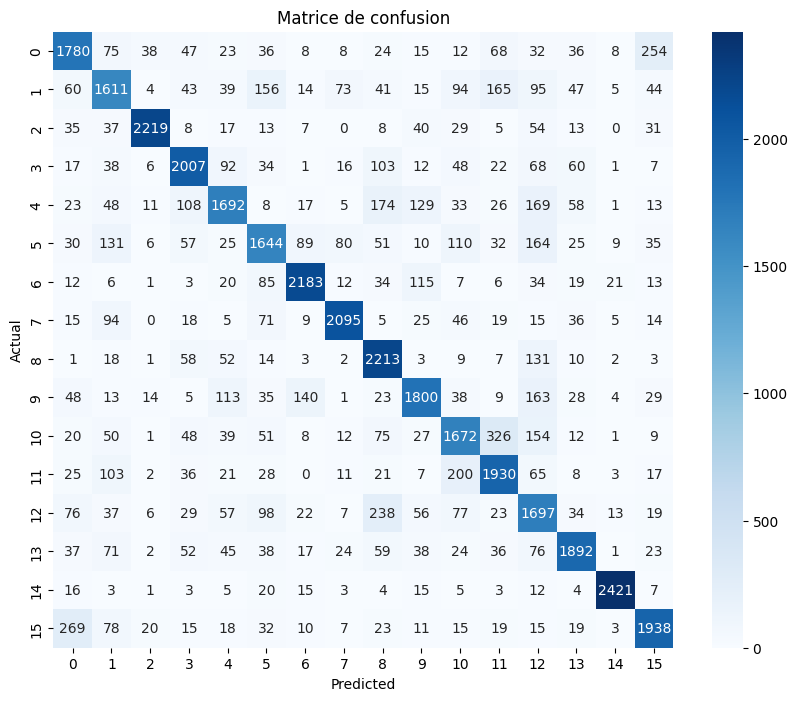

In [10]:
# matrice de confusion
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
cm = confusion_matrix(all_labels, all_predictions)

# Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion')
plt.show()

                        precision    recall  f1-score   support

                letter       0.72      0.72      0.72      2464
                  form       0.67      0.64      0.66      2506
                 email       0.95      0.88      0.92      2516
           handwritten       0.79      0.79      0.79      2532
         advertisement       0.75      0.67      0.71      2515
     scientific report       0.70      0.66      0.68      2498
scientific publication       0.86      0.85      0.85      2571
         specification       0.89      0.85      0.87      2472
           file folder       0.71      0.88      0.79      2527
          news article       0.78      0.73      0.75      2463
                budget       0.69      0.67      0.68      2505
               invoice       0.72      0.78      0.75      2477
          presentation       0.58      0.68      0.62      2489
         questionnaire       0.82      0.78      0.80      2435
                resume       0.97      

<Figure size 1200x800 with 0 Axes>

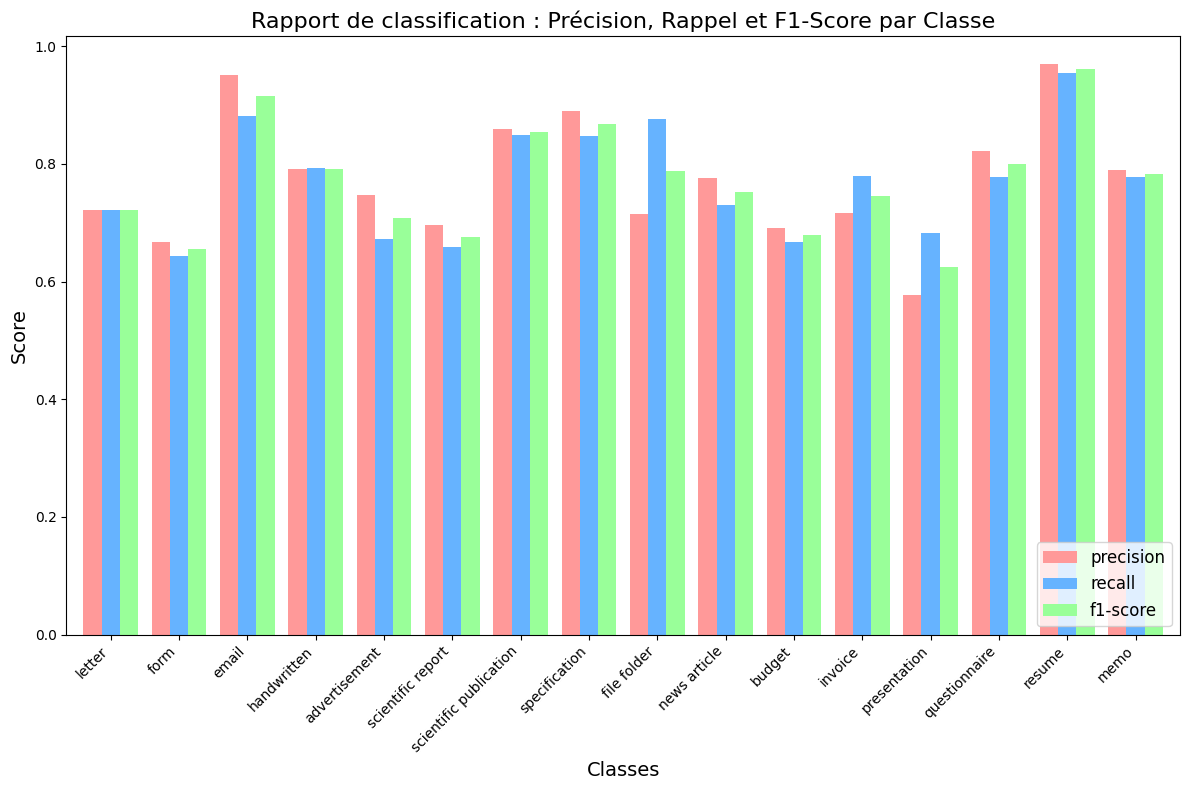

In [12]:
#rapport de classification
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report

from sklearn.metrics import classification_report
# Dictionnaire des labels (ajustez-le selon votre jeu de données)
labels_dict = {
    0: "letter", 1: "form", 2: "email", 3: "handwritten", 4: "advertisement",
    5: "scientific report", 6: "scientific publication", 7: "specification",
    8: "file folder", 9: "news article", 10: "budget", 11: "invoice",
    12: "presentation", 13: "questionnaire", 14: "resume", 15: "memo"
}
# Obtenir un rapport détaillé avec précision, rappel et F1-score pour chaque classe
rapport = classification_report(all_labels, all_predictions, target_names=list(labels_dict.values()))
print(rapport)


# Générer le rapport de classification en tant que dictionnaire
rapport_dict = classification_report(all_labels, all_predictions, target_names=list(labels_dict.values()), output_dict=True)

# Convertir le dictionnaire en DataFrame pour plus de simplicité
df_rapport = pd.DataFrame(rapport_dict).transpose()

# Sélectionner uniquement les classes (exclure 'accuracy', 'macro avg', 'weighted avg')
df_classes = df_rapport.iloc[:-3, :3]  # On prend uniquement precision, recall et f1-score pour chaque classe

# Créer une figure pour visualiser le rapport
plt.figure(figsize=(12, 8))

# Tracer un graphique à barres pour chaque métrique (précision, rappel, f1-score)
df_classes.plot(kind='bar', figsize=(12, 8), width=0.8, color=['#FF9999', '#66B3FF', '#99FF99'])

# Ajouter des légendes et des titres
plt.title("Rapport de classification : Précision, Rappel et F1-Score par Classe", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xticks(rotation=45, ha="right")  # Rotation des labels de classe pour meilleure lisibilité
plt.legend(loc='lower right', fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.show()
